<div class="alert alert-block alert-info">
<b> Всем привет! 


Я закончила соревнование 3 месте. 

К сожалению, 'те самые' настройки модели я потеряла :( 

Однако логика моего исследования, если кому интересно, представлена ниже.
    
Спасибо!
    
</div>

<br/><font size="6"><b>MegaFon Accelerator. Классификация. </b></font>.<br/>

# Описание проекта

## Постановка задачи

Необходимо построить модель, которая предсказывает к какому из трех сегментов (0,1,2) относится каждый абонент.

## Описание данных

Обучающая выборка contest_train.csv состоит из следующих столбцов:

* ID - идентификатор абонента.
* TARGET - соответствующий абоненту сегмент.
* FEATURE_0…FEATURE_259 — характеристики абонента.

* Тестовая выборка contest_test.csv состоит из столбца ID и следующими за ним столбцами FEATURE_0 … FEATURE_259

*Точность предсказания оценивается по метрике macro-f1_score.*


*Распределение Public/Private - 50%/50%*

<a name="0."></a><br/>
<font size="4"><b>0. Подгрузка библиотек и самописные функции</b></font>.<br/>

In [1]:
import numpy as np
import pandas as pd

import joblib
import time
import warnings

from plotly.subplots import make_subplots

from sklearn.metrics  import f1_score
from sklearn.metrics  import precision_score
from sklearn.metrics  import recall_score
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.utils import shuffle
from termcolor import colored
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import seaborn as sns
from scipy import stats as st
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer

from sklearn.metrics import classification_report

from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.dummy import DummyClassifier

In [2]:
!pip install catboost

     |████████████████████████████████| 67.3MB 61kB/s 


In [3]:
from catboost import CatBoostClassifier

In [4]:
#Определяем болд
def bold(): 
    return "\033[1m"

def bold_end(): 
    return "\033[0m"

#Ставим формат для нумериков
pd.options.display.float_format = '{: >10.2f}'.format

#Убираем ворнинги
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
#**Функция print_basic_info, для вывода информации о массиве, и его переменных.**

#* base - название базы данных
#* info - 1: вывод информации о массиве, другое: не вывод
#* describe - 1: вывод описания переменных массива, другое: не вывод        
#* duplicat - 1: вывод количества полных дублей
#* head - n: вывод примера базы (вывод n - строк), n < 1: не вывод

def print_basic_info(base, info, describe, duplicat, head):
    if info == 1:
        print("\n", bold(), colored('info','green'), bold_end(), "\n")
        print( base.info())  
    if head >= 1:
        print("\n", bold(),colored('head','green'),bold_end())
        display(base.head(head))
    if describe == 1:
        print("\n", bold(),colored('describe','green'),bold_end(),"\n")
        for i in base.columns:
            print("\n", bold(), colored(i,'blue'),bold_end(),"\n", base[i].describe())
    if duplicat == 1:
        print("\n", bold(),colored('duplicated','green'),bold_end(),"\n")
        print(base[base.duplicated() == True][base.columns[0]].count())

In [6]:
#__Функция ft_namecount__, для вывода названия переменной, частотной нормированной таблицы и описания переменной.

#5 входных параметров:

#* *base* - название базы данных
#* *index* - название переменной в базе
#* *table* - 1: вывод частотной нормированной таблицы, 0: не вывод
#* *sort* - 1: сортировка таблицы по лейблам переменной, 0: не сортировка
#* *describe* - 1: вывод описания переменной, 0: не вывод

def ft_name_count (base, name , table, sort, describe):
    print(bold(), colored(name,'blue') , bold_end(), "\n")
    if table != 0:
        s = (base[name].value_counts(normalize=True))
        if sort != 0:
            s.sort_index(inplace=True)
        print(s)
    if describe != 0:
        print(base[name].describe())

<a name="1."></a><br/>
<font size="6"><b>1. Подготовка данных</b></font>.<br/>

**Открываем**

In [7]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [8]:
#Работаю локально, онлайн путь другой

contest_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/contest_train.csv', sep=',',decimal='.' , index_col= 'ID')
contest_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/contest_test.csv', sep=',',decimal='.', index_col = 'ID')


In [9]:
print_basic_info(contest_train,1,0,1,3)


  info  

<class 'pandas.core.frame.DataFrame'>
Index: 24521 entries, 0d1c880d23ff018 to 5044ce165577a9f
Columns: 261 entries, TARGET to FEATURE_259
dtypes: float64(260), int64(1)
memory usage: 49.0+ MB
None

  head 


,TARGET,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,...,FEATURE_220,FEATURE_221,FEATURE_222,FEATURE_223,FEATURE_224,FEATURE_225,FEATURE_226,FEATURE_227,FEATURE_228,FEATURE_229,FEATURE_230,FEATURE_231,FEATURE_232,FEATURE_233,FEATURE_234,FEATURE_235,FEATURE_236,FEATURE_237,FEATURE_238,FEATURE_239,FEATURE_240,FEATURE_241,FEATURE_242,FEATURE_243,FEATURE_244,FEATURE_245,FEATURE_246,FEATURE_247,FEATURE_248,FEATURE_249,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0d1c880d23ff018,1,2.00,2.00,0.00,0.00,0.00,0.00,0.00,-114.53,-17.22,0.00,0.00,0.00,25.26,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,2.49,0.00,3.77,-2.17,0.00,-11.51,0.00,0.00,0.00,0.00,0.00,0.00,0.71,-166.13,16.50,-109.95,-10.26,-35.40,...,2.00,22.00,56.00,-18.20,1.00,433.15,4.00,52.00,55.72,0.00,33.78,0.00,48.38,-6.55,0.00,62.75,111.84,213.05,20.00,18.00,225.39,0.00,0.00,0.00,160.78,0.00,2.00,0.00,19.00,0.00,39.00,2.00,223.12,290.02,1.00,1.00,0.00,1.00,2.00,2.00
1579ba37fd82c1f,0,1.00,1.00,0.00,0.00,1.00,0.00,0.00,329.83,nan,3.00,2.00,1.00,767.32,30.00,11.00,1.00,0.00,0.00,1.00,0.00,0.00,-1.78,0.00,-27.72,-2.05,0.00,-48.53,0.00,0.00,0.00,0.00,0.00,0.00,4198.42,6935.03,3326.12,4750.74,8171.98,6420.86,...,1.00,288.00,540.00,1573.71,1.00,885.76,104.00,230.00,349.87,0.00,6367.48,0.00,106.45,6535.30,0.00,429.12,325.66,720.58,361.00,135.00,911.83,0.00,81.00,1.00,485.23,0.00,0.00,0.00,1.00,0.00,25.00,82.00,479.62,611.65,0.00,1.00,0.00,1.00,1.00,1.00
790086f721c7f5e,1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,17.43,-6.68,0.00,0.00,0.00,1453.02,4.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.04,0.00,-0.09,-1.50,0.00,-6.23,0.00,0.00,0.00,0.00,0.00,0.00,-89.25,9.44,0.79,61.09,4.37,13.73,...,2.00,92.00,161.00,2.54,1.00,504.08,13.00,89.00,81.64,0.00,13.53,0.00,50.18,29.68,0.00,228.21,173.90,395.11,28.00,15.00,343.97,0.00,0.00,0.00,67.81,0.00,0.00,0.00,78.00,0.00,119.00,0.00,352.27,564.57,1.00,1.00,0.00,1.00,1.00,1.00



  duplicated  

0


In [10]:
print_basic_info(contest_test,1,0,1,3)


  info  

<class 'pandas.core.frame.DataFrame'>
Index: 9484 entries, 0749d313171551f to f91280c1f3aeac3
Columns: 260 entries, FEATURE_0 to FEATURE_259
dtypes: float64(260)
memory usage: 18.9+ MB
None

  head 


,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,FEATURE_9,FEATURE_10,FEATURE_11,FEATURE_12,FEATURE_13,FEATURE_14,FEATURE_15,FEATURE_16,FEATURE_17,FEATURE_18,FEATURE_19,FEATURE_20,FEATURE_21,FEATURE_22,FEATURE_23,FEATURE_24,FEATURE_25,FEATURE_26,FEATURE_27,FEATURE_28,FEATURE_29,FEATURE_30,FEATURE_31,FEATURE_32,FEATURE_33,FEATURE_34,FEATURE_35,FEATURE_36,FEATURE_37,FEATURE_38,FEATURE_39,...,FEATURE_220,FEATURE_221,FEATURE_222,FEATURE_223,FEATURE_224,FEATURE_225,FEATURE_226,FEATURE_227,FEATURE_228,FEATURE_229,FEATURE_230,FEATURE_231,FEATURE_232,FEATURE_233,FEATURE_234,FEATURE_235,FEATURE_236,FEATURE_237,FEATURE_238,FEATURE_239,FEATURE_240,FEATURE_241,FEATURE_242,FEATURE_243,FEATURE_244,FEATURE_245,FEATURE_246,FEATURE_247,FEATURE_248,FEATURE_249,FEATURE_250,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0749d313171551f,1.00,1.00,0.00,0.00,0.00,0.00,0.00,-46.95,-45.02,0.00,0.00,0.00,375.28,3.00,3.00,0.00,0.00,0.00,0.00,0.00,0.00,6.43,0.00,2.32,-0.91,0.00,-22.23,0.00,0.00,0.00,0.00,0.00,0.00,-42.82,1.15,85.29,-23.31,-38.46,9.58,0.00,...,1.00,97.00,178.00,38.76,0.00,415.01,2.00,73.00,73.72,0.00,-34.98,0.00,6.48,37.03,0.00,449.59,177.51,596.62,8.00,19.00,97.92,0.00,0.00,0.00,134.42,0.00,0.00,0.00,2.00,0.00,0.00,0.00,190.59,162.05,1.00,0.00,1.00,1.00,1.00,1.00
ddb093edbbbe1ef,0.00,0.00,1.00,0.00,0.00,0.00,0.00,343.63,nan,3.00,1.00,0.00,1151.53,8.00,8.00,1.00,0.00,0.00,1.00,0.00,0.00,8.92,0.00,-13.34,-1.00,0.00,-52.52,0.00,0.00,0.00,0.00,0.00,0.00,612.40,6078.98,5783.61,4778.63,7561.82,6912.77,0.00,...,2.00,60.00,146.00,394.90,4.00,594.21,5.00,194.00,200.01,0.00,6466.66,0.00,4391.99,10918.51,0.00,59.05,183.03,178.58,69.00,132.00,803.11,0.00,56.00,53.00,550.70,0.00,0.00,1.00,4.00,0.00,5.00,109.00,594.57,685.50,1.00,1.00,0.00,1.00,1.00,2.00
cef8538a6054069,0.00,0.00,0.00,0.00,1.00,0.00,0.00,909.18,3260.45,3.00,1.00,1.00,595.16,4.00,4.00,0.00,0.00,0.00,0.00,0.00,0.00,-2.81,197.60,7.13,16.61,3.90,-99.62,0.00,0.00,0.00,0.00,0.00,0.00,-14.79,-7.92,-4.37,-12.63,26.08,-21.53,10.00,...,1.00,0.00,10.00,192.36,0.00,468.26,0.00,30.00,5.82,0.00,5.60,41.00,1088.63,1049.88,0.00,-21.71,6.28,-13.56,0.00,0.00,284.93,0.00,0.00,297.00,9.59,0.00,0.00,0.00,0.00,0.00,0.00,297.00,10.21,300.40,0.00,0.00,0.00,1.00,1.00,1.00



  duplicated  

0


In [11]:
ft_name_count(contest_train, 'TARGET' , 1, 1, 0)

 TARGET  

0         0.71
1         0.23
2         0.06
Name: TARGET, dtype: float64


База состоит из 24521 кейсов в трейне и 9484 в тесте <br> 260 features. 

Дублей нет. 

Не все заполнены. Есть пропуски.

**TARGET** - Есть дисбаланс. Сильный. Больше всего сегмента 0. Меньше всего 2. 
Поэтому скорее всего нам потребуется бустировать часть выборки, при обучении модели.

 ## Попробуем понять какие столбцы нам не понадобятся и обработать пропуски

In [12]:
# посмотрим есть ли не нумеррик стобцы
for i in range(0,len(contest_train.columns)):
  if contest_train.dtypes[i] != 'int64' and contest_train.dtypes[i] != 'float64':
    print(contest_train.dtypes[i])

for i in range(0,len(contest_test.columns)):
  if contest_test.dtypes[i] != 'int64' and contest_test.dtypes[i] != 'float64':
    print(contest_test.dtypes[i])

# таких нет

In [13]:
# посмотрим есть столбцы запоненные менее чем на 75%
for i in range(0,len(contest_train.columns)):
  if contest_train[contest_train.columns[i]].isnull().mean() > 0.75:
    print(contest_train.columns[i], " - ", contest_train[contest_train.columns[i]].isnull().mean())

FEATURE_189  -  0.986746054402349


Удалим FEATURE_189

In [14]:
# посмотрим есть столбцы запоненные менее чем на 65%
for i in range(0,len(contest_train.columns)):
  if contest_train[contest_train.columns[i]].isnull().mean() > 0.65:
    print(contest_train.columns[i], " - ", contest_train[contest_train.columns[i]].isnull().mean())

FEATURE_189  -  0.986746054402349
FEATURE_190  -  0.7011133314302027
FEATURE_194  -  0.7032747440968965


Удалим FEATURE_189

In [15]:
# посмотрим есть столбцы запоненные менее чем на 3 значенияи
for i in range(0,len(contest_train.columns)):
  if len(contest_train[contest_train.columns[i]].unique()) < 3:
    print(contest_train.columns[i], " - ", len(contest_train[contest_train.columns[i]].unique()))

FEATURE_2  -  2
FEATURE_3  -  1
FEATURE_4  -  2
FEATURE_5  -  2
FEATURE_6  -  2
FEATURE_11  -  2
FEATURE_15  -  2
FEATURE_16  -  2
FEATURE_17  -  2
FEATURE_18  -  2
FEATURE_19  -  2
FEATURE_140  -  2
FEATURE_144  -  1
FEATURE_159  -  2
FEATURE_249  -  1
FEATURE_254  -  2
FEATURE_255  -  2
FEATURE_256  -  1


Смело можем удалить если только 1 значение (FEATURE_3, FEATURE_144, FEATURE_256)

Удалим:

In [16]:
f_del = {"FEATURE_189","FEATURE_3", "FEATURE_144", "FEATURE_256"}

contest_train = contest_train.drop(f_del, axis=1)
contest_test = contest_test.drop(f_del, axis=1)

In [17]:
# Заполним пропуски на основе 4 ближайших сеседей.
imputer = KNNImputer(n_neighbors=4)

# Фит train
imputer.fit(contest_train.drop(['TARGET'], axis=1))

KNNImputer(add_indicator=False, copy=True, metric='nan_euclidean',
           missing_values=nan, n_neighbors=4, weights='uniform')

Транформ

In [18]:
# закоментировала этот кусок ииза длительности исполнения

#contest_train_after = imputer.transform(contest_train.drop(['TARGET'], axis=1))
#contest_test_aftet = imputer.transform(contest_test)

# проверим, что шейп не попыл
#print(contest_train_after.shape, contest_train.shape, contest_test_aftet.shape)

Сделаем пандавским датафреймом

In [19]:
# pd_contest_train_after = pd.DataFrame(contest_train_after, index = contest_train.index,
#                                       columns = contest_train.drop(['TARGET'], axis=1).columns.values)

# pd_contest_train_after['TARGET'] = contest_train['TARGET']

# pd_contest_test_after = pd.DataFrame(contest_test_aftet, index = contest_test.index ,
#                                       columns = contest_test.columns.values)

Сохраним новые базы, чтоб каждый раз не заполнять (т.к. долго)

In [20]:
#pd_contest_train_after.to_csv("/content/drive/MyDrive/Colab Notebooks/datasets/contest_train_KNNImputer.csv")
#pd_contest_test_after.to_csv("/content/drive/MyDrive/Colab Notebooks/datasets/contest_test_KNNImputer.csv")

При необходимости - загрузим заполненные базы

In [21]:
pd_contest_train_after = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/contest_train_KNNImputer.csv', sep=',',decimal='.' , index_col= 'ID')
pd_contest_test_after = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/contest_test_KNNImputer.csv', sep=',',decimal='.', index_col = 'ID')


Проверим заполненность

In [22]:
# трейн
for i in pd_contest_train_after.columns:
    if pd_contest_train_after[pd_contest_train_after[i].isnull() == True]['TARGET'].sum() > 0:
        print(i, pd_contest_train_after[pd_contest_train_after[i].isnull() == True]['TARGET'].sum())

In [23]:
# тест
for i in pd_contest_test_after.columns:
    if pd_contest_test_after[pd_contest_test_after[i].isnull() == True]['FEATURE_0'].sum() > 0:
        print(i, pd_contest_test_after[pd_contest_test_after[i].isnull() == True]['FEATURE_0'].sum())

Почистим от inf значений, чтобы исключить ошибку

In [24]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

cl_contest_train = clean_dataset(pd_contest_train_after)
cl_contest_test = clean_dataset(pd_contest_test_after)

#### Разабьем данные на выборки

In [25]:
features = cl_contest_train.drop(['TARGET'], axis=1)
target = contest_train['TARGET']
features_test = cl_contest_test

In [26]:
#разбиваем, стратифицируем
features_train_big, features_valid, target_train_big, target_valid = train_test_split(features, target , test_size=0.20, 
                                                                              random_state=515093, stratify = target)

features_train, features_valid = np.array(features_train_big), np.array(features_valid)

#### Сделаем ресемплинг

За модель берем дерево принятия решения и делаем ресемплинг.

Меньше 0 сегмента, больше 2 сегмента 

In [27]:
def resample(features, target, repeat_down, repeat_up):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    features_two = features[target == 2]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    target_two = target[target == 2]

    features_resampled = pd.concat([features_zeros.sample(n =(int(len(features_zeros)*repeat_down)), 
                                                            replace=False,random_state=2)] + [features_ones] 
                                   + [features_two.sample(n =(int(len(features_two)*repeat_up)), 
                                                            replace=True,random_state=2)])
    
    target_resampled = pd.concat([target_zeros.sample(n =(int(len(target_zeros)*repeat_down)),
                                                        replace=False)] + [target_ones] 
                                 + [target_two.sample(n =(int(len(target_two)*repeat_up)), 
                                                            replace=True)])
    features_resampled, target_resampled = shuffle(features_resampled, target_resampled, random_state=12345)
    features_resampled.reset_index(drop = True, inplace = True)
    target_resampled.reset_index(drop = True, inplace = True)
    return features_resampled, target_resampled

In [28]:
# попробуем подобрать на RandomForestClassifier лучший вариант
base_up = pd.DataFrame()

model_RFC = RandomForestClassifier(n_estimators = 50, random_state = 2)

for i in np.arange(0.35, 0.42, 0.02):
    for j in np.arange(2.2, 2.6, 0.1):
        features_resampled, target_resampled = resample(features_train_big, target_train_big, i , j)
        model_RFC.fit(features_resampled, target_resampled)
        prediction = model_RFC.predict(features_valid)
        target_names = ['Seg-0', 'Seg-1', 'Seg-2']
        for r in classification_report(target_valid, prediction, target_names=target_names).split("\n"):
          t = r.split( )
          if len(t) == 5 and t[0] == 'Seg-0':
            base_up.loc[str(round(i,2)) + " " + str(round(j,2)),'Seg-0'] = float(t[3])
          if len(t) == 5 and t[0] == 'Seg-1':
            base_up.loc[str(round(i,2)) + " " + str(round(j,2)),'Seg-1'] = float(t[3])
          if len(t) == 5 and t[0] == 'Seg-2':
            base_up.loc[str(round(i,2)) + " " + str(round(j,2)),'Seg-2'] = float(t[3])
        base_up.loc[str(round(i,2)) + " " + str(round(j,2)) ,'Macro F1'] = f1_score(target_valid, prediction, average='macro')

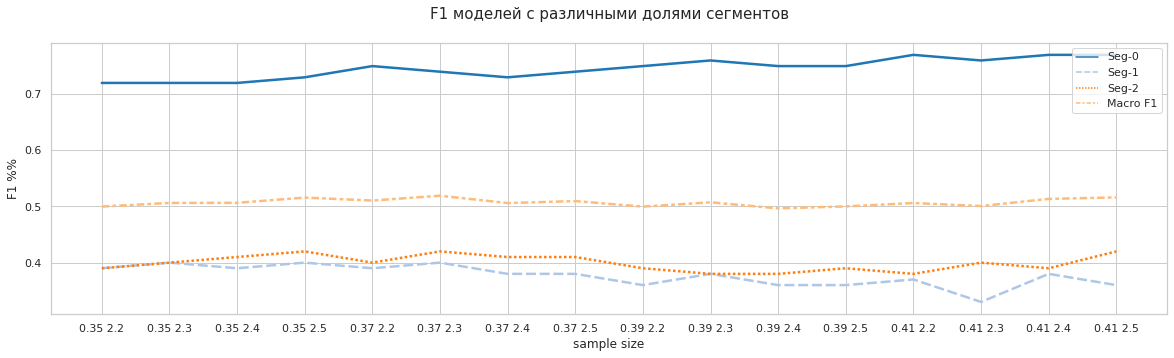

In [29]:
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (20,5)) 
sns.lineplot(data=base_up, palette="tab20", linewidth=2.5)
plt.title("F1 моделей с различными долями сегментов\n", fontsize=15)
plt.ylabel("F1 %%")
plt.xlabel("sample size")
#plt.ylim((0.1, 0.6)) 
plt.show()

In [30]:
# возьмем
features_resampled, target_resampled = resample(features_train_big, target_train_big, 0.39, 2.2)
features_resampled, target_resampled = np.array(features_resampled), target_resampled

In [31]:
target_resampled.value_counts(normalize=True)

0         0.43
1         0.36
2         0.21
Name: TARGET, dtype: float64

<a name="2."></a><br/>
<font size="6"><b>2. Обучение модели </b></font>.<br/>

In [32]:
# cделаем функцию с нужными нам параметрами
def put_in_base_test(base_res, model, features_train, target_train, features_valid, target_valid):
    model.fit(features_train, target_train)
    target = target_valid
    features = features_valid 
    proba = pd.DataFrame(model.predict_proba(features_valid), columns = ['0','1','2'])
    proba['predict'] = pd.Series(model.predict(features_valid))    
    prediction = proba['predict']
    accuracy, precision, recall, f1 = [], [], [], []
    accuracy.append(accuracy_score(target, prediction))
    precision.append(precision_score(target, prediction, average='macro'))
    recall.append(recall_score(target, prediction, average='macro'))
    f1.append(f1_score(target, prediction, average='macro'))
    target_names = ['Seg - 0', 'Seg - 1', 'Seg - 2']
    # будем печатать подробный отчет
    print(classification_report(target, prediction, target_names=target_names))
    base_res.loc[str(model).split('(')[0],'accuracy'] = np.mean(accuracy)
    base_res.loc[str(model).split('(')[0],'precision'] = np.mean(precision)
    base_res.loc[str(model).split('(')[0],'recall'] = np.mean(recall)
    base_res.loc[str(model).split('(')[0],'f1'] = np.mean(f1)
    target_names = ['Seg-0', 'Seg-1', 'Seg-2']
    for r in classification_report(target_valid, prediction, target_names=target_names).split("\n"):
      t = r.split( )
    if len(t) == 5 and t[0] == 'Seg-0':
      base_res.loc[str(model).split('(')[0],'Seg-0'] = float(t[3])
    if len(t) == 5 and t[0] == 'Seg-1':
      base_res.loc[str(model).split('(')[0],'Seg-1'] = float(t[3])
    if len(t) == 5 and t[0] == 'Seg-2':
      base_res.loc[str(model).split('(')[0],'Seg-2'] = float(t[3])    
    return base_res, prediction, model

In [33]:
# Тренировать будем на базе resampled
features_train, target_train = features_resampled, target_resampled

Прикинем несколко моделей

### **RandomForestClassifier**

In [34]:
#Будем подбирать параметры гридсерчем

parameters = {'max_depth':[i for i in range(15,26,1)] , 'n_estimators':[i for i in range(50,500,50)], 
              'max_features':[80,90,95,100], 'random_state':[1234]}

clf = GridSearchCV(RandomForestClassifier(), param_grid = parameters, scoring = 'f1_macro')
#clf.fit(features_train, target_train)
#print(clf.best_params_)

In [35]:
model_RFC = RandomForestClassifier(max_depth = 20, n_estimators = 450, max_features = 90, random_state = 2)

In [36]:
info = pd.DataFrame()

info, predictions_RFC, model_RFC = put_in_base_test(info, model_RFC, features_train, target_train, features_valid, target_valid)

              precision    recall  f1-score   support

     Seg - 0       0.81      0.73      0.77      3475
     Seg - 1       0.36      0.47      0.41      1130
     Seg - 2       0.42      0.43      0.42       300

    accuracy                           0.65      4905
   macro avg       0.53      0.54      0.53      4905
weighted avg       0.68      0.65      0.66      4905



#### **LGBMClassifier**


In [37]:
#Будем подбирать параметры гридсерчем

parameters = {'learning_rate':[0.15,0.1,0.05,0.01,0.005,0.001], 'num_leaves':[i for i in range(4,30,1)],
              'random_state': [i for i in range(4,300,10)]}

clf = GridSearchCV(LGBMClassifier(n_jobs = -1), param_grid = parameters, scoring = 'f1_macro')

#clf.fit(features_resampled, target_resampled)
#print(clf.best_params_)

In [38]:
model_LGBM = LGBMClassifier(random_state=123, n_jobs = -1, n_estimators = 500, boosting_type = 'gbdt')

info, predictions_LGBM, model_LGBM = put_in_base_test(info, model_LGBM, features_train, 
                                                      target_train, features_valid, target_valid)

              precision    recall  f1-score   support

     Seg - 0       0.82      0.71      0.76      3475
     Seg - 1       0.35      0.51      0.41      1130
     Seg - 2       0.47      0.35      0.40       300

    accuracy                           0.64      4905
   macro avg       0.55      0.52      0.53      4905
weighted avg       0.69      0.64      0.66      4905



#### **AdaBoostClassifier + RandomForestClassifier**

*Делаем вложенную модель. RandomForestClassifier в AdaBoostClassifier*

In [39]:
#Будем подбирать параметры гридсерчем

grid = {'n_estimators' : [i for i in range(5,25,5)], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0],
       'algorithm' : ['SAMME', 'SAMME.R']}

clf = AdaBoostClassifier(DecisionTreeClassifier())
rs = GridSearchCV(clf, grid, scoring = 'f1_macro')

#rs.fit(features_train, target_train)
#AdaBoostRegressor_best_params1 = rs.best_params_

In [40]:
model_Ada = AdaBoostClassifier(RandomForestClassifier(max_depth = 20, n_estimators = 500, max_features = 90, random_state = 2),
                               n_estimators=200, learning_rate=0.15, algorithm = 'SAMME.R')

info, predictions_Ada, model_Ada = put_in_base_test(info, model_Ada, features_train, target_train, features_valid, target_valid)

              precision    recall  f1-score   support

     Seg - 0       0.81      0.73      0.77      3475
     Seg - 1       0.37      0.48      0.42      1130
     Seg - 2       0.44      0.44      0.44       300

    accuracy                           0.65      4905
   macro avg       0.54      0.55      0.54      4905
weighted avg       0.69      0.65      0.67      4905



In [41]:
display(info.sort_values(by = 'f1', ascending = False))

,accuracy,precision,recall,f1
AdaBoostClassifier,0.65,0.54,0.55,0.54
RandomForestClassifier,0.65,0.53,0.54,0.53
LGBMClassifier,0.64,0.55,0.52,0.53


In [42]:
info['f1'].values

array([0.53173184, 0.52521419, 0.54057204])

**AdaBoostClassifier + DecisionTreeClassifier()** чуть чуть лучше




Сможем ли уменьшить количество параметров?

In [43]:
# Сможем ли уменьшить количество параметров?
feature_importances_info = pd.DataFrame()
feature_importances_info['columns'] = features_test.columns
feature_importances_info['importances'] = model_Ada.feature_importances_
feature_importances_info.query("importances == 0")

,columns,importances
4,FEATURE_5,0.00
246,FEATURE_249,0.00


2 признаки можно исключить без потери качества. 

In [44]:
features_test = features_test.drop(['FEATURE_5','FEATURE_249'], axis=1)
features = features.drop(['FEATURE_5','FEATURE_249'], axis=1)



##Финализируем модель




In [45]:
final_model = model_Ada
prediction = predictions_Ada

info_test = info[info.index == 'AdaBoostClassifier']

#### Проверим ее

In [46]:
#Сравним дамми
dummy_model = DummyClassifier(strategy='stratified')


info_test, predictions_dummy, dummy_model = put_in_base_test(info_test, dummy_model, features_train, 
                                                             target_train, features_valid, target_valid)


              precision    recall  f1-score   support

     Seg - 0       0.69      0.43      0.53      3475
     Seg - 1       0.22      0.33      0.27      1130
     Seg - 2       0.06      0.21      0.09       300

    accuracy                           0.39      4905
   macro avg       0.32      0.32      0.30      4905
weighted avg       0.55      0.39      0.44      4905



In [47]:
display(info_test.sort_values(by = 'f1', ascending = False))

,accuracy,precision,recall,f1
AdaBoostClassifier,0.65,0.54,0.55,0.54
DummyClassifier,0.39,0.32,0.32,0.30


AdaBoostClassifier значительно лучше дамми

In [48]:
#**Зависимость от объема выборки**

#делаем базу. добавляем по 10 кейсов увеличивая семпл
base_min = pd.DataFrame()
for i in range(30,1000,10):
    base_min.loc[i,'mean_absolute_error'] = f1_score(target_valid[0:i], final_model.predict(features_valid[0:i]), average='macro')

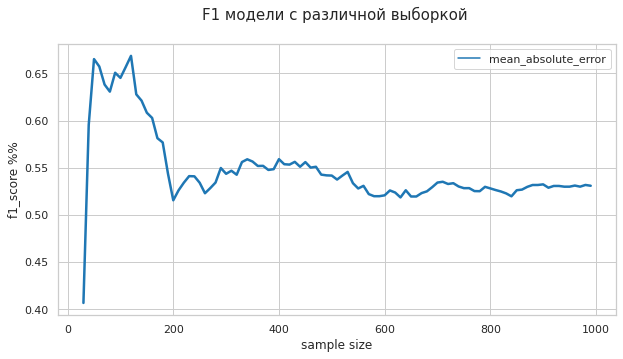

In [49]:
#строим график
sns.set(style="whitegrid")
plt.figure(figsize = (10,5)) 
sns.lineplot(data=base_min, palette="tab20", linewidth=2.5)
plt.title("F1 модели с различной выборкой \n", fontsize=15)
plt.ylabel("f1_score %%")
plt.xlabel("sample size")
plt.show()

Может ведет себя не очень стабильно при небольшой выборке и далее разброс меньше, но остается достаточно сильный. Это что может быть связанно с несбалансированностью классов на валидационной выборке.

Переобучим модель на всей выборке (ресемплированной)

In [50]:
# возьмем
features_resampled, target_resampled = resample(features, target, 0.39, 2.3)
features_resampled, target_resampled = np.array(features_resampled), target_resampled

final_model.fit(features_resampled, target_resampled)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=RandomForestClassifier(bootstrap=True,
                                                         ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=20,
                                                         max_features=90,
                                                         max_leaf_nodes=None,
                                                         max_samples=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                             

#### Экспортируем предсказания на тестовой выборке

In [51]:
output = pd.DataFrame({'ID': contest_test.index, 
                       'Predicted': pd.Series(final_model.predict(features_test), dtype='int32')})

output.to_csv('sub_kiseleva.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


<font size="6"><b>Вывод</b></font>.<br/>

* Удалила признаки с одним значением и с незаполненностью более 95% .
* Пустоты в столбцах заполнила c помощью KNNImputer - 4 .
* При обучении модели потребовалась ручная ребалансировка классов - 
  * Количество кейсов нулевого 0 класса умножила на  0.39
  * А кейсы 2 класса размножила в 2.2.
* Наилучшие показатели у модели на основе AdaBoostClassifier(RandomForestClassifier(max_depth = 19, n_estimators = 500, random_state = 1234), n_estimators=100,  learning_rate=0.2)